In [1]:
from gerda.core.virusPropagationModel import *
import gerda.utilities.VPM_plotting as vpm_plot
%matplotlib inline
%load_ext autoreload
import glob
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
#%load_ext memory_profiler

In [2]:
geopath = 'input_data/geo/'
geofiles = {0:'Buildings_Gangelt_MA_1.csv',
            1:'Buildings_Gangelt_MA_3.csv',
           }         

# Build world 

### Choose which world to initate

Here we choose, which version of the world to use for the vaccination-screens in this notebook.
By default we use the reduced version of the world, in order to avoid excessive runtimes (reduced version approx. 2h, complete version approx. 12h).
However one can comment out the second line and uncomment the first line, to run the screen on the large world, we based the results in the manuscript on.

In [3]:
#world_to_pick = 0 ## choosing complete version
world_to_pick = 1 ## choosing reduced version

### Initiate the selected world without infections

In [4]:
n_initially_infected=0
modeledWorld = ModeledPopulatedWorld(initial_infections=n_initially_infected, geofile_name=geopath+geofiles[world_to_pick], input_schedules='schedules_v2')
n_people = modeledWorld.number_of_people
print('Number of agents: '+ str(n_people))

Number of agents: 1003


### Definition of the function to initially infect specified susceptible agents

All agents with IDs in the list 'IDs' will be initially infected

In [5]:
def infect_world(world, IDs=[1]):
    ID_list = world.get_remaining_possible_initial_infections(IDs)
    world.initialize_infection(specific_people_ids=ID_list)

# Run initial simulation

Here we run an intitial (unperturbed) infection wave, to be used in the vaccination strategy which is based on the forecasted infection wave.

#### Define Simulation characteristics

timesteps_initial_sim: Number of simulated timesteps in hours for the initial simulation <br>
general_infectivity: Scaling factor for the general infectivity (default value = 0.3) <br>
general_interaction_frequency: Expected interaction-frequency over all individuals per hour (default-value=2/h)

In [6]:
timesteps_initial_sim=3000
general_infectivity=0.3
general_interaction_frequency=2

#### Introduce infected agents

Before starting the simulation the generated world is copied to ensure the same origin for each simulation. The number of initial infections is defined by 'n_initially_infected' (default=4).

In [7]:
world_to_use = copy.deepcopy(modeledWorld)

n_initially_infected=4

infect_world(world_to_use, IDs=[i+1 for i in range(n_initially_infected)])

amount of initially recovered agents: 0


#### Set up simulation with specified characteristics

In [8]:
simulation_initial_wave = Simulation(world_to_use, timesteps_initial_sim, run_immediately=False)

simulation_initial_wave.change_agent_attributes({'all':{'behaviour_as_infected':{'value':general_infectivity,'type':'replacement'}}})
simulation_initial_wave.interaction_frequency=general_interaction_frequency

#### Run simulation

In [9]:
simulation_initial_wave.simulate()

### CHECKPOINT FOR USER:

If the plot below does not show an infection outbreak (due to the stochastic nature of our model, some infection-waves may die out); please re-run the two cells above and continue if the plot shows an outbreak.

#### Plot status-trajectories

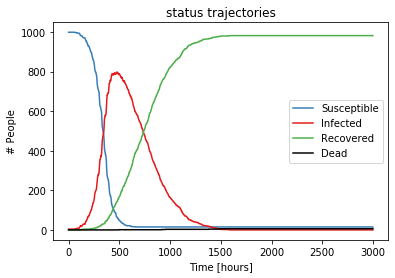

In [10]:
simulation_initial_wave.plot_status_timecourse()

# Define vaccination orders for different vaccination strategies

Vaccination orders are defined by ordered lists of agent IDs following specified sorting rules.
These are:
1. sorted by [forecasted infection wave](#sorted)
2. sorted by [overrepresentation](#overrep) of agent type in infection spreading
3. sorted by [agent interactivity](#activity)
4. sorted by [households](#house)
5. sorted by [age](#age) (descending)
6. sorted [randomly](#random)

## Sorting strategies, based on previous simulation

The following two vaccination strategies are based on results derived from predceeding simulations.

### 1. Sorted by forecasted infection wave <a id='sorted'></a>

Here we return the order, in which agents got infected in the previous simulation (simulation_initial_wave).
This gives us a vaccination-order, based on the simulated outbreak.

#### Define function to sort agents according to forecasted infection wave

In [ ]:
def get_previous_infections(previous_simulation):
    df_inf = previous_simulation.get_infection_event_information()
    infected = list(df_inf['h_ID'].values)
    all_agents = infected+[a.ID for a in previous_simulation.people if a.ID not in infected]
    return all_agents

#### Create list of agents sorted by forecasted infection wave, by executing defined function

In [ ]:
agents_forecasted = get_previous_infections(simulation_initial_wave)

### 2. Sorted by over-representation (agent types) <a id='overrep'></a>

Here we sort agents by the the number of infections caused, relative to the number of individuals of the respective type (termed over-representation). Order of individual agents of the repective is not specified.

#### Define function to sort agents by type. The sequence of types is defined in sorted list "agent_types". 

In [ ]:
def get_ids_by_agent_type(world,agent_types_sorted_by_overrepresentation):
    ids_by_type = {s_type:[] for s_type in agent_types_sorted_by_overrepresentation}
    for p in world.people:
        ids_by_type[p.schedule['type']].append(p.ID)
    ordered_ids = []
    for s_type in agent_types_sorted_by_overrepresentation:
        ordered_ids.extend(ids_by_type[s_type])
    return ordered_ids

#### Create list of agents sorted by type, by executing defined function

Please note that the order of agent types, acording to over-representation, is not determined automatically in this notebook. Instead we used the order, applied in the manuscript and hard-coded it in the variable "agent_types_sorted_by_overrepresentation"

In [ ]:
agent_types_sorted_by_overrepresentation = ['under_age', 'adult', 'teacher', 'medical_professional', 'public_worker', 'pensioner']
agents_by_type = get_ids_by_agent_type(modeledWorld,agent_types_sorted_by_overrepresentation=agent_types_sorted_by_overrepresentation)

### 3. Sorted by Interactivity <a id='activity'></a>

Here we sort agents, based on their "interactivity". This is determined by performing a preceding simulation of 168 hours (1 week), without any introduced infection (so the determining the interactivity is not affected by the infection-spread); and subsequntly sorting agents according to the number of interactions, they had.

#### Define function to sort agents with decreasing number of total interactions from a preceding simulation without infection spreading

In [ ]:
def get_ids_by_interactions(simulation_no_infections):
    contacts = simulation_no_infections.get_contact_distributions(min_t=0, max_t=168)[1]
    contacts_mean = contacts.groupby('ID').mean()
    contacts_mean.reset_index(inplace=True)
    contacts_sorted = contacts_mean.sort_values('interactions', axis=0, ascending=False)
    to_recover_list = list(contacts_sorted['ID'].values)
    return to_recover_list

#### Run the preceding simulation without infection spreading

In [ ]:
timesteps_blank_sim=168
uninfectedWorld = copy.deepcopy(modeledWorld)
simulation_no_infections = Simulation(uninfectedWorld, timesteps_blank_sim, run_immediately=False)
simulation_no_infections.interaction_frequency=general_interaction_frequency
simulation_no_infections.simulate()

#### Create the list of agents sorted by decreasing number of total interactions, by executing defined function

In [ ]:
agents_by_interactions = get_ids_by_interactions(simulation_no_infections)

## Sorting-strategies, based on population-structure

The following strategies are based on the population structure of the simulated world and do not require preceeding simulations

### 4. Sorted by household <a id='house'></a>

Define function to sort agents by their households. First one member of each household is chosen. When there is one member for each household a second member is chosen for each household of size 2 and bigger. After that a third member is chosen for each household of size 3 and bigger. ...

In [ ]:
def get_ids_by_households(world):
    ai = world.get_agent_info()
    home_count_dict = dict(zip(list(ai.groupby('Home').count().index), list(ai.groupby('Home').count()['ID'])))
    ai['Home_size']=ai['Home'].map(home_count_dict)

    ai_sorted = ai.sort_values('Home')
    home_list = ai_sorted['Home'].values

    count_list=[]
    predecessor = 0
    count = 1
    for x in home_list:
        if x == predecessor:
            count +=1
        else:
            count = 1
        count_list.append(count)
        predecessor = x

    ai_sorted['Home_position'] = count_list

    ai_sorted.sort_values('Home_position') ## dataframe
    households_sorted = ai_sorted.sort_values(by=['Home_position'])
    to_recover_list = list(households_sorted['ID']) ### id list
    return to_recover_list

#### Create the list of agents sorted by households, by executing defined function

In [ ]:
agents_by_households = get_ids_by_households(modeledWorld)

### 5. Sorted by age <a id='age'></a>

Here we sort agents by age (in descending order) and thus implicitly by likelyhood for severe consequences of infection, to vaccinate accordingly.

#### Define function to sort agents by age, descending

In [ ]:
def get_ids_by_age(world):
    ages_and_ids = [(p.age, p.ID) for p in world.people]
    ages_and_ids_df = pd.DataFrame(ages_and_ids, columns=['age','id'])
    ages_and_ids_df.sort_values('age', ascending=False, inplace=True)
    to_recover_list = list(ages_and_ids_df['id'])
    return to_recover_list

#### Create the list of agents sorted by age, descending

In [ ]:
agents_by_age = get_ids_by_age(modeledWorld)

### 6. Random sorting <a id='random'></a>

The last vaccination-strategy is to vaccinate individuals in random order

#### Define function to randomly shuffle the order of agents

In [ ]:
def get_random_id_list(world):
    agent_ids = [p.ID for p in world.people]
    random.shuffle(agent_ids)
    return agent_ids

#### Create a list of agents with random order

In [ ]:
agents_random = get_random_id_list(modeledWorld)

# Run vaccination-fraction screens for different strategies

With ordered list of individuals, by different vaccination-strategies; we now perform the screen of vaccination-fractions among the population, in specified increments. 

#### Define function to vaccinate a certain fraction of agents in a specified order

This function vaccinates (setting initial agent-state to recovered) a given fraction of individuals in the world to be simulated (argument "world") (specified by argument "frac"), according to the strategy-specific agent-order (argument "ordered_agents")

In [ ]:
# define function to vaccinate list of agents
def vaccinate_world(world, frac, ordered_agents):
    agents_to_vaccinate = ordered_agents[:int(frac*len(ordered_agents))]
    for p in world.people:
        if p.ID in agents_to_vaccinate:
            p.set_initially_recovered()

#### Create a dictionary to access the previously created ordered lists by keywords

In [ ]:
agent_orders = {'forecasted':agents_forecasted, 'overrepresentation':agents_by_type,
                'interactions':agents_by_interactions, 'households':agents_by_households,
                'age':agents_by_age, 'random':agents_random}

#### Define the fractions of agents to vaccinate

#### Define function to simulate the vaccination scenario with the defined fractions and agent orders

This cell defines the function, to run a vaccination-fraction screen for one strategy.
It takes a world to simulate ("modeledWorld"), a list of ordered agents to be vaccinated ("ordered_agents"), a list of vaccination-fractions to be tested ("fractions"), the number of seed-infections ("n_initially_infected" by default 4) and the number of time-steps to be simulated ("timesteps_vaccination_sim" by default 3000) as arguments. 
For each specified fractions it vaccinates the first n agents in the list of ordered agents, sets the specified number of seed-infections (making sure none of these are vaccinated), sets the general infectivity ("behaviour_as_infected") to the default value (specified by perviously defined variable "general_infectivity") and finally  does the same for the interactivity (set to default value "general_interaction_frequency"). Then the system is simulated and relevant results (total number of total infections, total number of deceased and the maximum demand for ICU-treatment) are returned. 

In [ ]:
def simulate_fractions(modeledWorld, ordered_agents, fractions, n_initially_infected=4, timesteps_vaccination_sim=3000):
    results=pd.DataFrame(columns=['fraction','infected','icued','dead'])
    for frac in fractions:
        world_to_use = copy.deepcopy(modeledWorld)
        vaccinate_world(world_to_use, frac, ordered_agents)
        infect_world(world_to_use, IDs=[i+1 for i in range(n_initially_infected)])
        simulation_vaccinated_fraction = Simulation(world_to_use, timesteps_vaccination_sim, run_immediately=False)
        simulation_vaccinated_fraction.change_agent_attributes({'all':{'behaviour_as_infected':{'value':general_infectivity,'type':'replacement'}}})
        simulation_vaccinated_fraction.interaction_frequency=general_interaction_frequency
        simulation_vaccinated_fraction.simulate()
        cummulative_flags = simulation_vaccinated_fraction.get_flag_sums_over_time(specific_flags=['ICUed'])
        dead_agents = simulation_vaccinated_fraction.get_status_trajectories(specific_statuses=['D'])['D']['D'].iloc[-1]
        infected_agents = simulation_vaccinated_fraction.get_infection_event_information().shape[0]
        icued_agents = cummulative_flags['ICUed'].max()
        results.loc[frac,'fraction']=frac
        results.loc[frac,'infected']=infected_agents
        results.loc[frac,'icued']=icued_agents
        results.loc[frac,'dead']=dead_agents
    return results

#### Define a list of strategies to test by keywords, run the simulations for all fractions and all strategies and save relevant results

The cell below defines the list of strategies, one wants to test (by default all), sets the number of simulated timesteps for each run (recommended default is 3000) and finally defines the range and increment sizes of vaccination-fractions.
Then it runs the simulate_fractions-function for each strategy and writes te resulting pandas.DataFrames in a dictionary (results_dict) with the strategy-names as keys.

In [ ]:
strategies_to_test = ['forecasted', 'overrepresentation', 'interactions', 'households', 'age', 'random']
timesteps_vaccination_sim=3000

lowest_vaccination_fraction=0.1
highest_vaccination_fraction=0.91
increment_size=0.2

fractions = np.arange(lowest_vaccination_fraction, highest_vaccination_fraction, increment_size)

results_dict = {strategy: simulate_fractions(modeledWorld, agent_orders[strategy], fractions,timesteps_vaccination_sim=timesteps_vaccination_sim) for strategy in strategies_to_test}

# Plot results of vaccination screens

Here we generate a plot, representing figure 3 in the manuscript. The very left panel corresponds to Panel A in figure 3 and shows the number of total infections, relative to the number of non-vaccinated individuals. The middle panel corresponds to panel 3B, showing the same for deceased individuals. The very right panel corresponds to panel 3D and shows the maximum ICU-demand per 100000. Please note the Panel 3C from the manuscript can not be obtained in this notebook, since it relies on several replicates (100 in our study) of each simulation; and is thus infeasible for demonstration-purposes.

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

colors = {'random':'lightseagreen', 'interactions':'violet', 'age':'gold',
          'overrepresentation':'royalblue', 'households':'lightgreen', 'forecasted':'orange'}

for strategy in results_dict:
    fractions = results_dict[strategy]['fraction']
    axs[0].plot(fractions, results_dict[strategy]['infected']/(modeledWorld.number_of_people*(1-fractions)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy])
    axs[1].plot(fractions, results_dict[strategy]['dead']/(modeledWorld.number_of_people*(1-fractions)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy])
    axs[2].plot(fractions, (results_dict[strategy]['icued']/modeledWorld.number_of_people)*100000.0,
                label=strategy, lw=2, alpha=0.7, color=colors[strategy])
    
for ax in axs:
    ax.set_xlabel('fraction of immunized population')
    
axs[0].set_ylabel('fraction of non immunized population')
axs[1].set_ylabel('fraction of non immunized population')
axs[2].set_ylabel('max ICU demand per 100.000')

axs[0].set_title('Infections')
axs[1].set_title('Death')
axs[2].set_title('ICU Demand')

axs[0].legend()

plt.tight_layout()